In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os.path as op
import time

import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint, History, CallbackList, BaseLogger
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
from keras.metrics import accuracy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from fastmri_recon.data.test_generators import RandomShapeGenerator
from fastmri_recon.helpers.adversarial_training import compile_models, adversarial_training_loop
from fastmri_recon.helpers.image_tboard_cback import TensorBoardImage
from fastmri_recon.helpers.keras_utils import wasserstein_loss
from fastmri_recon.models.discriminator import discriminator_model, generator_containing_discriminator_multiple_outputs
from fastmri_recon.models.unet import unet
from fastmri_recon.helpers.utils import keras_psnr, keras_ssim
from fastmri_recon.helpers.evaluate import psnr, ssim, mse, nmse

In [15]:
run_params = {
    'n_layers': 4, 
    'pool': 'max', 
    "layers_n_channels": [16, 32, 64, 128], 
    'layers_n_non_lins': 2,
}

im_size = 64

def generator_model():
    model = unet(input_size=(im_size, im_size, 1), **run_params, compile=False)
    model.name = 'Reconstructor'
    return model

In [16]:
# model definitions
g = generator_model()
# prev_run_id = 'unet_wo_lastrelu_af4_1572013433'
# prev_epoch = 500
# chkpt_path = f'checkpoints/{prev_run_id}-{prev_epoch}.hdf5'
# g.load_weights(chkpt_path)
d = discriminator_model(im_size)
d_on_g = generator_containing_discriminator_multiple_outputs(g, d, im_size=im_size)

In [17]:
# model compiling
perceptual_loss = 'mae'

discriminator_lr = 1e-4
d_on_reconstructor_lr = 1e-3

compile_models(
    d, 
    g, 
    d_on_g, 
    d_lr=discriminator_lr, 
    d_on_g_lr=d_on_reconstructor_lr, 
    perceptual_loss=perceptual_loss, 
    perceptual_weight=1.0,
)

In [18]:
n_batches_train = 1000
n_batches_val = 1
AF = 2
train_gen = RandomShapeGenerator(af=AF, n_shapes=100, size=im_size, batch_size=1).flow_z_filled_random_shapes()
val_gen = RandomShapeGenerator(af=AF, n_shapes=100, size=im_size, batch_size=1).flow_z_filled_random_shapes()

epoch_num = 100
critic_updates = 5

run_id = f'unet_gan_af{AF}_{int(time.time())}'
chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

unet_gan_af2_1573827695


In [19]:
log_dir = op.join('logs/gan', run_id)

tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")
tboard_cback = TensorBoard(
    log_dir=log_dir, 
    write_graph=True, 
    update_freq=50,
)

chkpt_cback = ModelCheckpoint(chkpt_path, period=epoch_num)
selected_slice = 0
data = next(val_gen)
tboard_image_cback = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

log_dir_pre = op.join('logs/pregan', run_id)
gen_tensor = TensorBoard(
    log_dir=log_dir_pre
)
gen_tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")

tboard_image_cback_pre = TensorBoardImage(
    log_dir=log_dir_pre + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

In [20]:
%%time
# %debug
# overfitting trial
hist = adversarial_training_loop(
    g, 
    d, 
    d_on_g, 
    train_gen, 
    n_epochs=0, 
    n_batches=1, 
    n_critic_updates=5,
    callbacks=[tqdm_cb, tboard_cback, tboard_image_cback],
    include_d_metrics=True,
    gen_pre_training_steps=1000,
    pre_training_callbacks=[gen_tensor,gen_tqdm_cb,tboard_image_cback_pre]
)



CPU times: user 5min 9s, sys: 1min 33s, total: 6min 42s
Wall time: 4min 21s


In [21]:
sns.set_style('white')
def show_images(images, cols = 1, title=None, titles = None, scale = 1, save=False):
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(facecolor="white")
    with sns.color_palette("PuBuGn_d"):
        for n, (image, title) in enumerate(zip(images, titles)):
            a = fig.add_subplot(cols, np.ceil(n_images/float(cols)) +1 , n + 1)
            plt.imshow(image)
            a.set_title(title)
    #plt.colorbar()
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images * scale)
    if save:
        plt.savefig("/Users/WorkAccount/Desktop/generator_outputs")
    plt.show()

In [28]:
im_alias, im_true = next(train_gen)
im_pred = g.predict(im_alias)

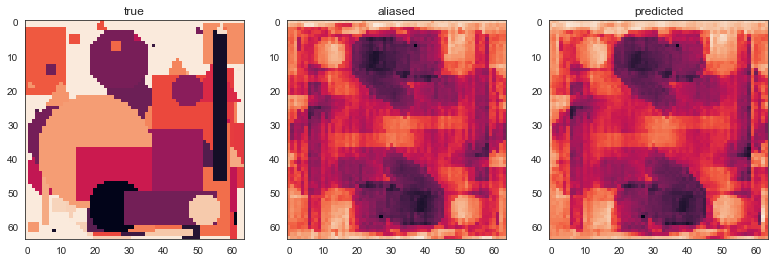

PSNR aliased image:  12.717844430412576 
PSNR predicted image: 12.779422478463635

MSE aliased image:  0.05181823762458961 
MSE predicted image: 0.05108869783993185

NMSE aliased image:  0.1095196738667653 
NMSE predicted image: 0.1079777657866913


In [31]:
show_images([np.squeeze(im_true), np.squeeze(im_alias),np.squeeze(im_pred)],
            titles=["true", "aliased", "predicted"],
            save=True)
print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
# print("ssim aliased image: ", ssim(im_true, im_alias), "\nssim predicted image:", ssim(im_true, im_pred))
print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))

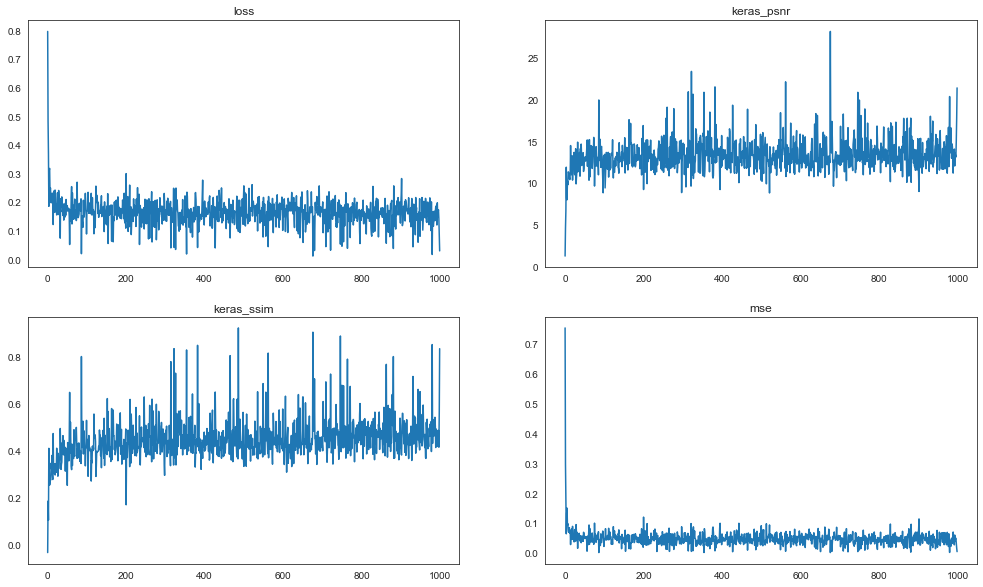

In [32]:
fig, axs = plt.subplots(2,2,figsize=(17,10))
images = [hist.history[l] for l in hist.history]
titles = [l for l in hist.history]
for i in range(len(titles)):
    plt.subplot(2, 2, i+1)
    plt.plot(images[i])
    plt.title(titles[i])
plt.savefig("/Users/WorkAccount/Desktop/training_metrics")
plt.show()